In [ ]:
import os
os.chdir('ImageBind')

import data
import torch
from models import imagebind_model
from models.imagebind_model import ModalityType

device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Instantiate model
model = imagebind_model.imagebind_huge(pretrained=True)
model.eval()
model.to(device)

In [2]:
from typing import Union
from docarray.documents import TextDoc, ImageDoc, AudioDoc

def embed(doc: Union[TextDoc, ImageDoc, AudioDoc]):
    """inplace embedding of document"""
    with torch.no_grad():
        if isinstance(doc, TextDoc):
            embedding = model({ModalityType.TEXT: data.load_and_transform_text([doc.text], device)})[ModalityType.TEXT]
        elif isinstance(doc, ImageDoc):
            embedding = model({ModalityType.VISION: data.load_and_transform_vision_data([doc.url], device)})[ModalityType.VISION]
        elif isinstance(doc, AudioDoc):
            embedding = model({ModalityType.AUDIO: data.load_and_transform_audio_data([doc.url], device)})[ModalityType.AUDIO]
        else:
            raise ValueError('one of the modality fields need to be set')

    doc.embedding = embedding.detach().cpu().numpy()[0]

    return doc


In [3]:
doc = ImageDoc(url='.assets/car_image.jpg')
doc = embed(doc)
doc

📄 ImageDoc : f883565 ...
╭─────────────────────────────┬───────────────────────────────────────────────────────────────────────────────────╮
│ Attribute                   │ Value                                                                             │
├─────────────────────────────┼───────────────────────────────────────────────────────────────────────────────────┤
│ url: ImageUrl               │ .assets/car_image.jpg                                                             │
│ embedding: NdArrayEmbedding │ NdArrayEmbedding of shape (1024,), dtype: float32                                 │
╰─────────────────────────────┴───────────────────────────────────────────────────────────────────────────────────╯

In [4]:
from docarray.index.backends.in_memory import InMemoryExactNNIndex

image_index = InMemoryExactNNIndex[ImageDoc]()
image_index.index([
    embed(doc) for doc in 
    [ImageDoc(url=img_path) for img_path in [".assets/dog_image.jpg", ".assets/car_image.jpg", ".assets/bird_image.jpg"]]
])

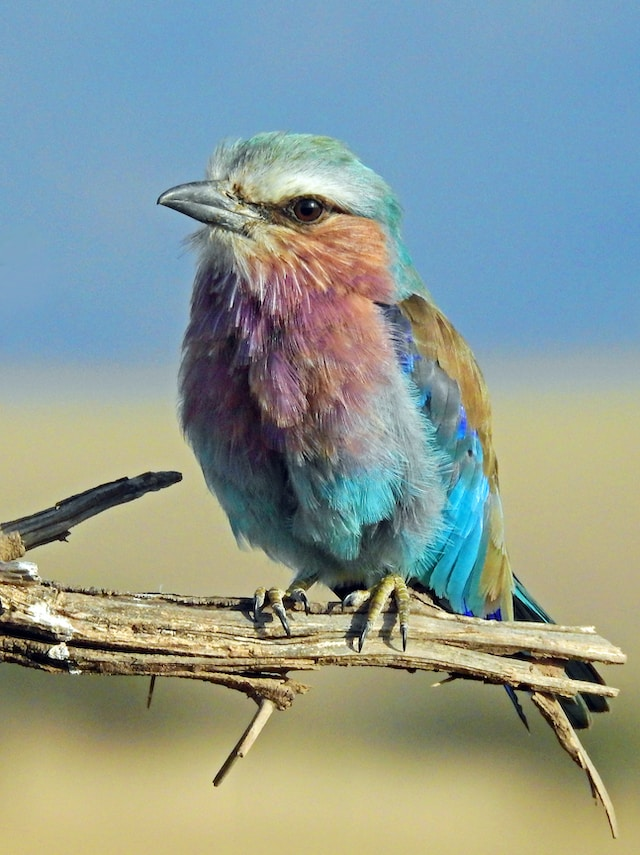

In [5]:
match = image_index.find(embed(TextDoc(text='bird')).embedding, search_field='embedding', limit=1) \
                   .documents[0]
match.url.display()

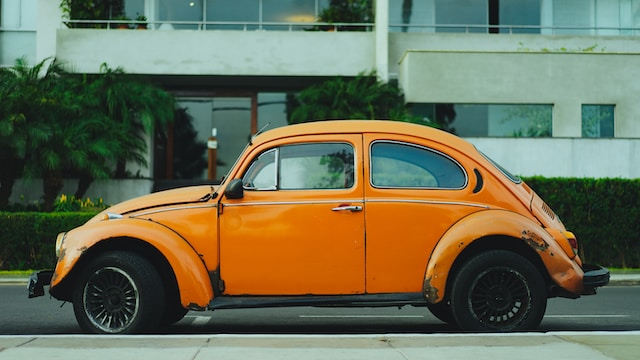

In [17]:
match = image_index.find(embed(TextDoc(text='machine')).embedding, search_field='embedding', limit=1) \
                   .documents[0]
match.url.display()

In [6]:
from docarray.index.backends.in_memory import InMemoryExactNNIndex

audio_index = InMemoryExactNNIndex[AudioDoc]()
audio_index.index([
    embed(doc) for doc in
    [AudioDoc(url=audio_path) for audio_path in [".assets/dog_audio.wav", ".assets/car_audio.wav", ".assets/bird_audio.wav"]]
])

In [7]:
match = audio_index.find(embed(TextDoc(text='bird')).embedding, search_field='embedding', limit=1) \
                   .documents[0]
match.url.display()

In [8]:
# using the same audio_index, find by image:
match = audio_index.find(embed(ImageDoc(url='.assets/car_image.jpg')).embedding, search_field='embedding', limit=1) \
									 .documents[0]
match.url.display()
# Displays the card sound